In [ ]:
import os
import numpy as np
import tifffile
import cv2
from matplotlib import pyplot as plt
from itertools import product

In [5]:
dir = r"D:/GitHub/cellpose/data/"
out = r"D:\data"
flist = os.listdir(dir)

if not os.path.exists(out):
    os.makedirs(out)

if not os.path.exists(dir):
    os.makedirs(dir)

Code used to divide the tiff files into Nuc, and Ecad data for cell segmentation

In [ ]:
img = []
for file in flist:
    temp = tifffile.imread(os.path.join(dir + file))
    Nuc = temp[0]
    ecad = temp[7]
    img.append(np.stack([Nuc,ecad]))

In [7]:
for i,items in enumerate(img):
    tifffile.imwrite(os.path.join(out,flist[i]),data=items,dtype='uint8',imagej=True)      

# -------------------------------------------------------------------------------------

In [ ]:
"""
    Original Code used for masters thesis 
"""

# def split_tiff_into_slices(input_folder, output_folder, slice_size=(512, 512), overlap=0):
#     """
#     Split multi-page TIFF images in a directory into smaller slices and save them in subfolders.

#     Args:
#         input_folder (str): Path to the folder containing input TIFF files.
#         output_folder (str): Path to the output folder where slices will be saved.
#         slice_size (tuple): Size of each slice (width, height).
#         overlap (int): Overlap between adjacent slices.

#     Returns:
#         None
#     """
#     if not os.path.exists(input_folder):
#         raise FileNotFoundError(f"Input folder '{input_folder}' does not exist.")

#     if not os.path.exists(output_folder):
#         os.makedirs(output_folder)

#     for filename in os.listdir(input_folder):
#         if filename.endswith('.tif') or filename.endswith('.tiff'):
#             input_file = os.path.join(input_folder, filename)
#             output_subfolder = os.path.join(output_folder, os.path.splitext(filename)[0])
#             os.makedirs(output_subfolder, exist_ok=True)

#             split_tiff(input_file, output_subfolder, slice_size, overlap)

#     print('Slicing completed for all images in the directory.')

# def split_tiff(input_file, output_folder, slice_size=(512, 512), overlap=64):
#     """
#     Split a multi-page TIFF image into smaller slices and save them as individual TIFF files.

#     Args:
#         input_file (str): Path to the input TIFF file.
#         output_folder (str): Path to the output folder where slices will be saved.
#         slice_size (tuple): Size of each slice (width, height).
#         overlap (int): Overlap between adjacent slices.

#     Returns:
#         None
#     """
   
#     image = tifffile.imread(input_file)

#     num_images, height, width = image.shape

#     slice_width, slice_height = slice_size

#     x_slices = (width - overlap) // (slice_width - overlap)
#     y_slices = (height - overlap) // (slice_height - overlap)

#     slice_count = 0
    
#     for i in range(x_slices):
#         for j in range(y_slices):
#             slices = []
#             for page in range(num_images):
#                 left = max(0, i * (slice_width - overlap))
#                 upper = max(0, j * (slice_height - overlap))
#                 right = min(width, left + slice_width)
#                 lower = min(height, upper + slice_height)

#                 slices.append(image[page, upper:lower, left:right])

#             # Stack slices along the third dimension to form a 3D array
#             stacked_slices = np.stack(slices, axis=0)

#             # Define the output file path
#             output_file = os.path.join(output_folder, f'{os.path.splitext(os.path.basename(input_file))[0]}_{left}_{upper}_{right}_{lower}.tiff')

#             # Write the stacked slices as a multi-page TIFF
#             tifffile.imwrite(output_file, stacked_slices,imagej=True)

#             slice_count += 1
                
#     print(f'Total {slice_count} slices saved in {output_folder}')
    

# # Example usage
# # input_folder = r"D:\GitHub\cellpose\output\input" # SATMA, Tumour 
# # output_folder = r"D:\GitHub\cellpose\output"

# input_folder = r"D:\data\ecad_nuc"
# output_folder = r"D:\data\ecad_nuc_split"

# split_tiff_into_slices(input_folder, output_folder)

In [20]:
def split_tiff_into_slices(input_folder, output_folder, slice_size=(512, 512), overlap=0):
    """
    Split multi-page TIFF images in a directory into smaller slices and save them in subfolders.

    Args:
        input_folder (str): Path to the folder containing input TIFF files.
        output_folder (str): Path to the output folder where slices will be saved.
        slice_size (tuple): Size of each slice (width, height).
        overlap (int): Overlap between adjacent slices.

    Returns:
        None
    """
    if not os.path.exists(input_folder):
        raise FileNotFoundError(f"Input folder '{input_folder}' does not exist.")

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith('.tif') or filename.endswith('.tiff'):
            input_file = os.path.join(input_folder, filename)
            output_subfolder = os.path.join(output_folder, os.path.splitext(filename)[0])
            os.makedirs(output_subfolder, exist_ok=True)

            split_tiff(input_file, output_subfolder, slice_size, overlap)

    print('Slicing completed for all images in the directory.')

def split_tiff(input_file, output_folder, slice_size=(512, 512), overlap=0):
    """
    Split a multi-page TIFF image into smaller slices and ensure full coverage.

    Args:
        input_file (str): Path to the input TIFF file.
        output_folder (str): Path to the output folder where slices will be saved.
        slice_size (tuple): Size of each slice (width, height).
        overlap (int): Overlap between adjacent slices.

    Returns:
        None
    """
    image = tifffile.imread(input_file)
    num_images, height, width = image.shape
    slice_width, slice_height = slice_size

    slice_count = 0
    x = 0
    while x < width:
        y = 0
        while y < height:
            # Adjust slice size for right and bottom edges
            right = min(x + slice_width, width)
            lower = min(y + slice_height, height)
            left = max(0, right - slice_width)  # Ensure fixed width
            upper = max(0, lower - slice_height)  # Ensure fixed height

            slices = [image[page, upper:lower, left:right] for page in range(num_images)]
            stacked_slices = np.stack(slices, axis=0)

            output_file = os.path.join(output_folder, f'{os.path.splitext(os.path.basename(input_file))[0]}_{left}_{upper}_{right}_{lower}.tiff')
            tifffile.imwrite(output_file, stacked_slices, imagej=True)

            slice_count += 1
            y += slice_height - overlap  # Move down

        x += slice_width - overlap  # Move right

    print(f'{slice_count} slices saved in {output_folder}')

# Example usage
input_folder = r"D:\data\ecad_nuc"
output_folder = r"D:\data\ecad_nuc_split"

split_tiff_into_slices(input_folder, output_folder)

195 slices saved in D:\data\ecad_nuc_split\Mx_BEGIN TMA EDGE_A15.ome
169 slices saved in D:\data\ecad_nuc_split\Mx_BEGIN TMA EDGE_H13.ome
143 slices saved in D:\data\ecad_nuc_split\Mx_BEGIN TMA NORMAL_E09.ome
144 slices saved in D:\data\ecad_nuc_split\Mx_BEGIN TMA TUMOUR_D17.ome
182 slices saved in D:\data\ecad_nuc_split\Mx_BEGIN TMA TUMOUR_J02.ome
42 slices saved in D:\data\ecad_nuc_split\Mx_SA TMA 2_G07.ome
49 slices saved in D:\data\ecad_nuc_split\Mx_SA TMA 5_G02.ome
42 slices saved in D:\data\ecad_nuc_split\Mx_SA TMA 5_G16.ome
42 slices saved in D:\data\ecad_nuc_split\Mx_SA TMA 5_I12.ome
42 slices saved in D:\data\ecad_nuc_split\Mx_SA TMA 5_I17.ome
42 slices saved in D:\data\ecad_nuc_split\Mx_SA TMA 5_J01.ome
36 slices saved in D:\data\ecad_nuc_split\Mx_SA TMA 5_J10.ome
42 slices saved in D:\data\ecad_nuc_split\Mx_SA TMA 5_J17.ome
36 slices saved in D:\data\ecad_nuc_split\Mx_Southampton TMA Research Block 5_G10.ome
49 slices saved in D:\data\ecad_nuc_split\Mx_Southampton TMA Resear

Total 195 slices saved in D:\data\ecad_nuc_split


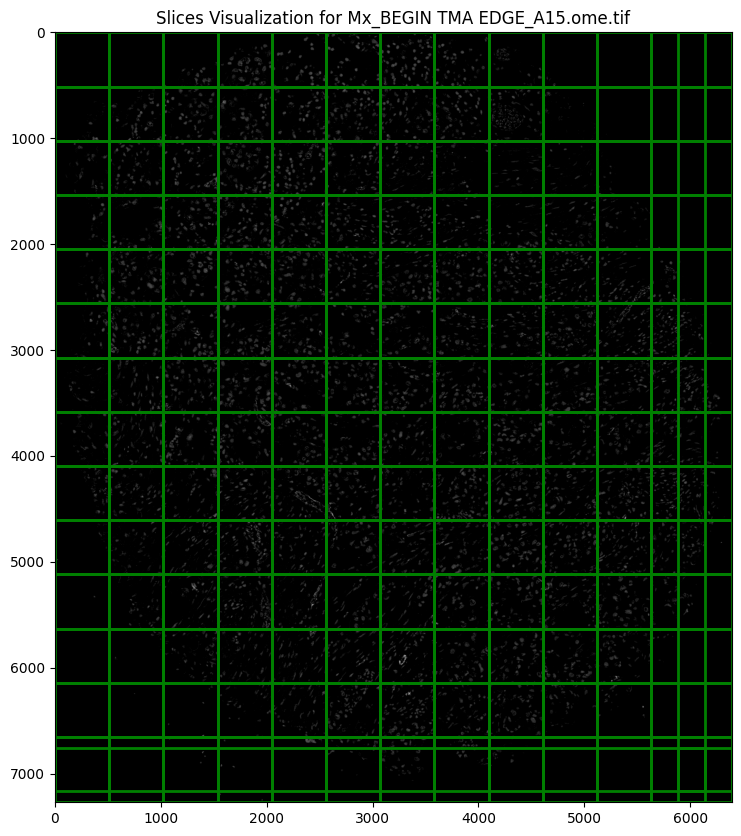

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches

# def split_tiff(input_file, output_folder, slice_size=(512, 512), overlap=0, visualize=False):
#     """
#     Split a multi-page TIFF image into smaller slices, ensuring no leftover space.

#     Args:
#         input_file (str): Path to the input TIFF file.
#         output_folder (str): Path to the output folder where slices will be saved.
#         slice_size (tuple): Size of each slice (width, height).
#         overlap (int): Overlap between adjacent slices.
#         visualize (bool): Whether to visualize the slices.

#     Returns:
#         None
#     """
#     image = tifffile.imread(input_file)
#     num_images, height, width = image.shape
#     slice_width, slice_height = slice_size

#     slice_boxes = set()  # Store slice bounding boxes

#     x = 0
#     while x < width:
#         y = 0
#         while y < height:
#             # Adjust slice size for right and bottom edges
#             right = min(x + slice_width, width)
#             lower = min(y + slice_height, height)
#             left = max(0, right - slice_width)  # Ensure fixed width
#             upper = max(0, lower - slice_height)  # Ensure fixed height

#             bbox = (left, upper, right, lower)
#             if bbox in slice_boxes:
#                 print(f"⚠️ Overlap detected: {bbox}")

#             slice_boxes.add(bbox)

#             # Extract and save slices
#             slices = [image[page, upper:lower, left:right] for page in range(num_images)]
#             stacked_slices = np.stack(slices, axis=0)

#             output_file = os.path.join(output_folder, f'{os.path.splitext(os.path.basename(input_file))[0]}_{left}_{upper}_{right}_{lower}.tiff')
#             tifffile.imwrite(output_file, stacked_slices, imagej=True)

#             y += slice_height - overlap  # Move down

#         x += slice_width - overlap  # Move right

#     print(f'Total {len(slice_boxes)} slices saved in {output_folder}')

#     # Visualize slices if requested
#     if visualize:
#         visualize_slices(image, slice_boxes, input_file, output_folder)

# def visualize_slices(image, slice_boxes, input_file, output_folder):
#     """
#     Visualizes the slices on the first frame of the TIFF image.

#     Args:
#         image (numpy array): TIFF image array.
#         slice_boxes (set): Set of bounding boxes (left, upper, right, lower).
#         input_file (str): Path to input file.
#         output_folder (str): Path to output folder.
#     """
#     fig, ax = plt.subplots(figsize=(10, 10))
#     ax.imshow(image[0], cmap="gray")  # Display first frame of the image

#     for bbox in slice_boxes:
#         left, upper, right, lower = bbox
#         width, height = right - left, lower - upper

#         # If overlap detected, use red, otherwise use green
#         color = "red" if list(slice_boxes).count(bbox) > 1 else "green"

#         rect = patches.Rectangle((left, upper), width, height, linewidth=2, edgecolor=color, facecolor='none')
#         ax.add_patch(rect)

#     plt.title(f"Slices Visualization for {os.path.basename(input_file)}")
#     plt.savefig(os.path.join(output_folder, f"{os.path.splitext(os.path.basename(input_file))[0]}_slices_visual.png"))
#     plt.show()

# # Example usage
# input_file = r"D:\data\ecad_nuc\Mx_BEGIN TMA EDGE_A15.ome.tif"
# output_folder = r"D:\data\ecad_nuc_split"

# split_tiff(input_file, output_folder, visualize=True)

In [ ]:
# def split_tiff_into_slices(input_folder, output_folder, slice_size=(512, 512), overlap=0):
#     """
#     Split multi-page TIFF images in a directory into smaller slices and save them in subfolders.

#     Args:
#         input_folder (str): Path to the folder containing input TIFF files.
#         output_folder (str): Path to the output folder where slices will be saved.
#         slice_size (tuple): Size of each slice (width, height).
#         overlap (int): Overlap between adjacent slices.

#     Returns:
#         None
#     """
#     if not os.path.exists(input_folder):
#         raise FileNotFoundError(f"Input folder '{input_folder}' does not exist.")

#     if not os.path.exists(output_folder):
#         os.makedirs(output_folder)

#     for filename in os.listdir(input_folder):
#         if filename.endswith('.tif') or filename.endswith('.tiff'):
#             input_file = os.path.join(input_folder, filename)
#             output_subfolder = os.path.join(output_folder, os.path.splitext(filename)[0])
#             os.makedirs(output_subfolder, exist_ok=True)

#             split_tiff(input_file, output_subfolder, slice_size, overlap)

#     print('Slicing completed for all images in the directory.')

# def split_tiff(input_file, output_folder, slice_size=(512, 512), overlap=64):
#     """
#     Split a multi-page TIFF image into smaller slices and save them as individual TIFF files.

#     Args:
#         input_file (str): Path to the input TIFF file.
#         output_folder (str): Path to the output folder where slices will be saved.
#         slice_size (tuple): Size of each slice (width, height).
#         overlap (int): Overlap between adjacent slices.

#     Returns:
#         None
#     """
   
#     image = tifffile.imread(input_file)
        
#     image = np.asarray(image)

#     height, width = image.shape
   
#     slice_width, slice_height = slice_size

#     x_slices = (width - overlap) // (slice_width - overlap)
#     y_slices = (height - overlap) // (slice_height - overlap)

#     slice_count = 0
    
 
#     for i in range(x_slices):
#         for j in range(y_slices):
#             left = max(0, i * (slice_width - overlap))
#             upper = max(0, j * (slice_height - overlap))
#             right = min(width, left + slice_width)
#             lower = min(height, upper + slice_height)

#             slice_img = image[upper:lower, left:right]
        
#             output_file = os.path.join(output_folder, f'{os.path.splitext(os.path.basename(input_file))[0]}_{left}_{upper}_{right}_{lower}_seg.tiff')
#             tifffile.imwrite(output_file, slice_img)
#             slice_count += 1
            
                
#     print(f'Total {slice_count} slices saved in {output_folder}')
    

# # Example usage
# input_folder = r"D:\data\ecad_nuc"
# output_folder = r"D:\data\ecad_nuc_split"
# split_tiff_into_slices(input_folder, output_folder)